<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/09_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00


## 9.1 Working with Sequences

### 9.1.3 Training

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
class Data(d2l.DataModule):
  def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
    self.save_hyperparameters()
    self.time = torch.arange(1, T + 1, dtype=torch.float32)      # T = 1, 0000, 1000
    self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2  # x = sin(0.01T) + N(0, 1) * 0.2

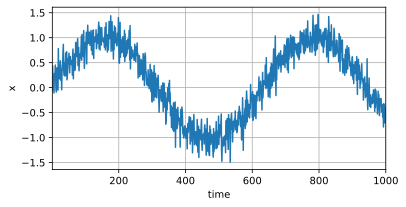

In [6]:
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [12]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
  features = [self.x[i : self.T - self.tau + i] for i in range(self.tau)]
  self.features = torch.stack(features, 1)
  self.labels = self.x[self.tau:].reshape((-1, 1))
  i = slice(0, self.num_train) if train else slice(self.num_train, None)
  return self.get_tensorloader([self.features, self.labels], train, i)
